
📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BodyFat   436 non-null    float64
 1   Original  436 non-null    object 
 2   Sex       436 non-null    object 
 3   Age       436 non-null    int64  
 4   Weight    436 non-null    float64
 5   Height    436 non-null    float64
 6   Neck      436 non-null    float64
 7   Chest     436 non-null    float64
 8   Abdomen   436 non-null    float64
 9   Hip       436 non-null    float64
 10  Thigh     436 non-null    float64
 11  Knee      436 non-null    float64
 12  Ankle     436 non-null    float64
 13  Biceps    436 non-null    float64
 14  Forearm   436 non-null    float64
 15  Wrist     436 non-null    float64
dtypes: float64(13), int64(1), object(2)
memory usage: 54.6+ KB

📊 Descriptive Statistics:
         count       mean        std      min       25%      50%      75%  \
BodyFat 

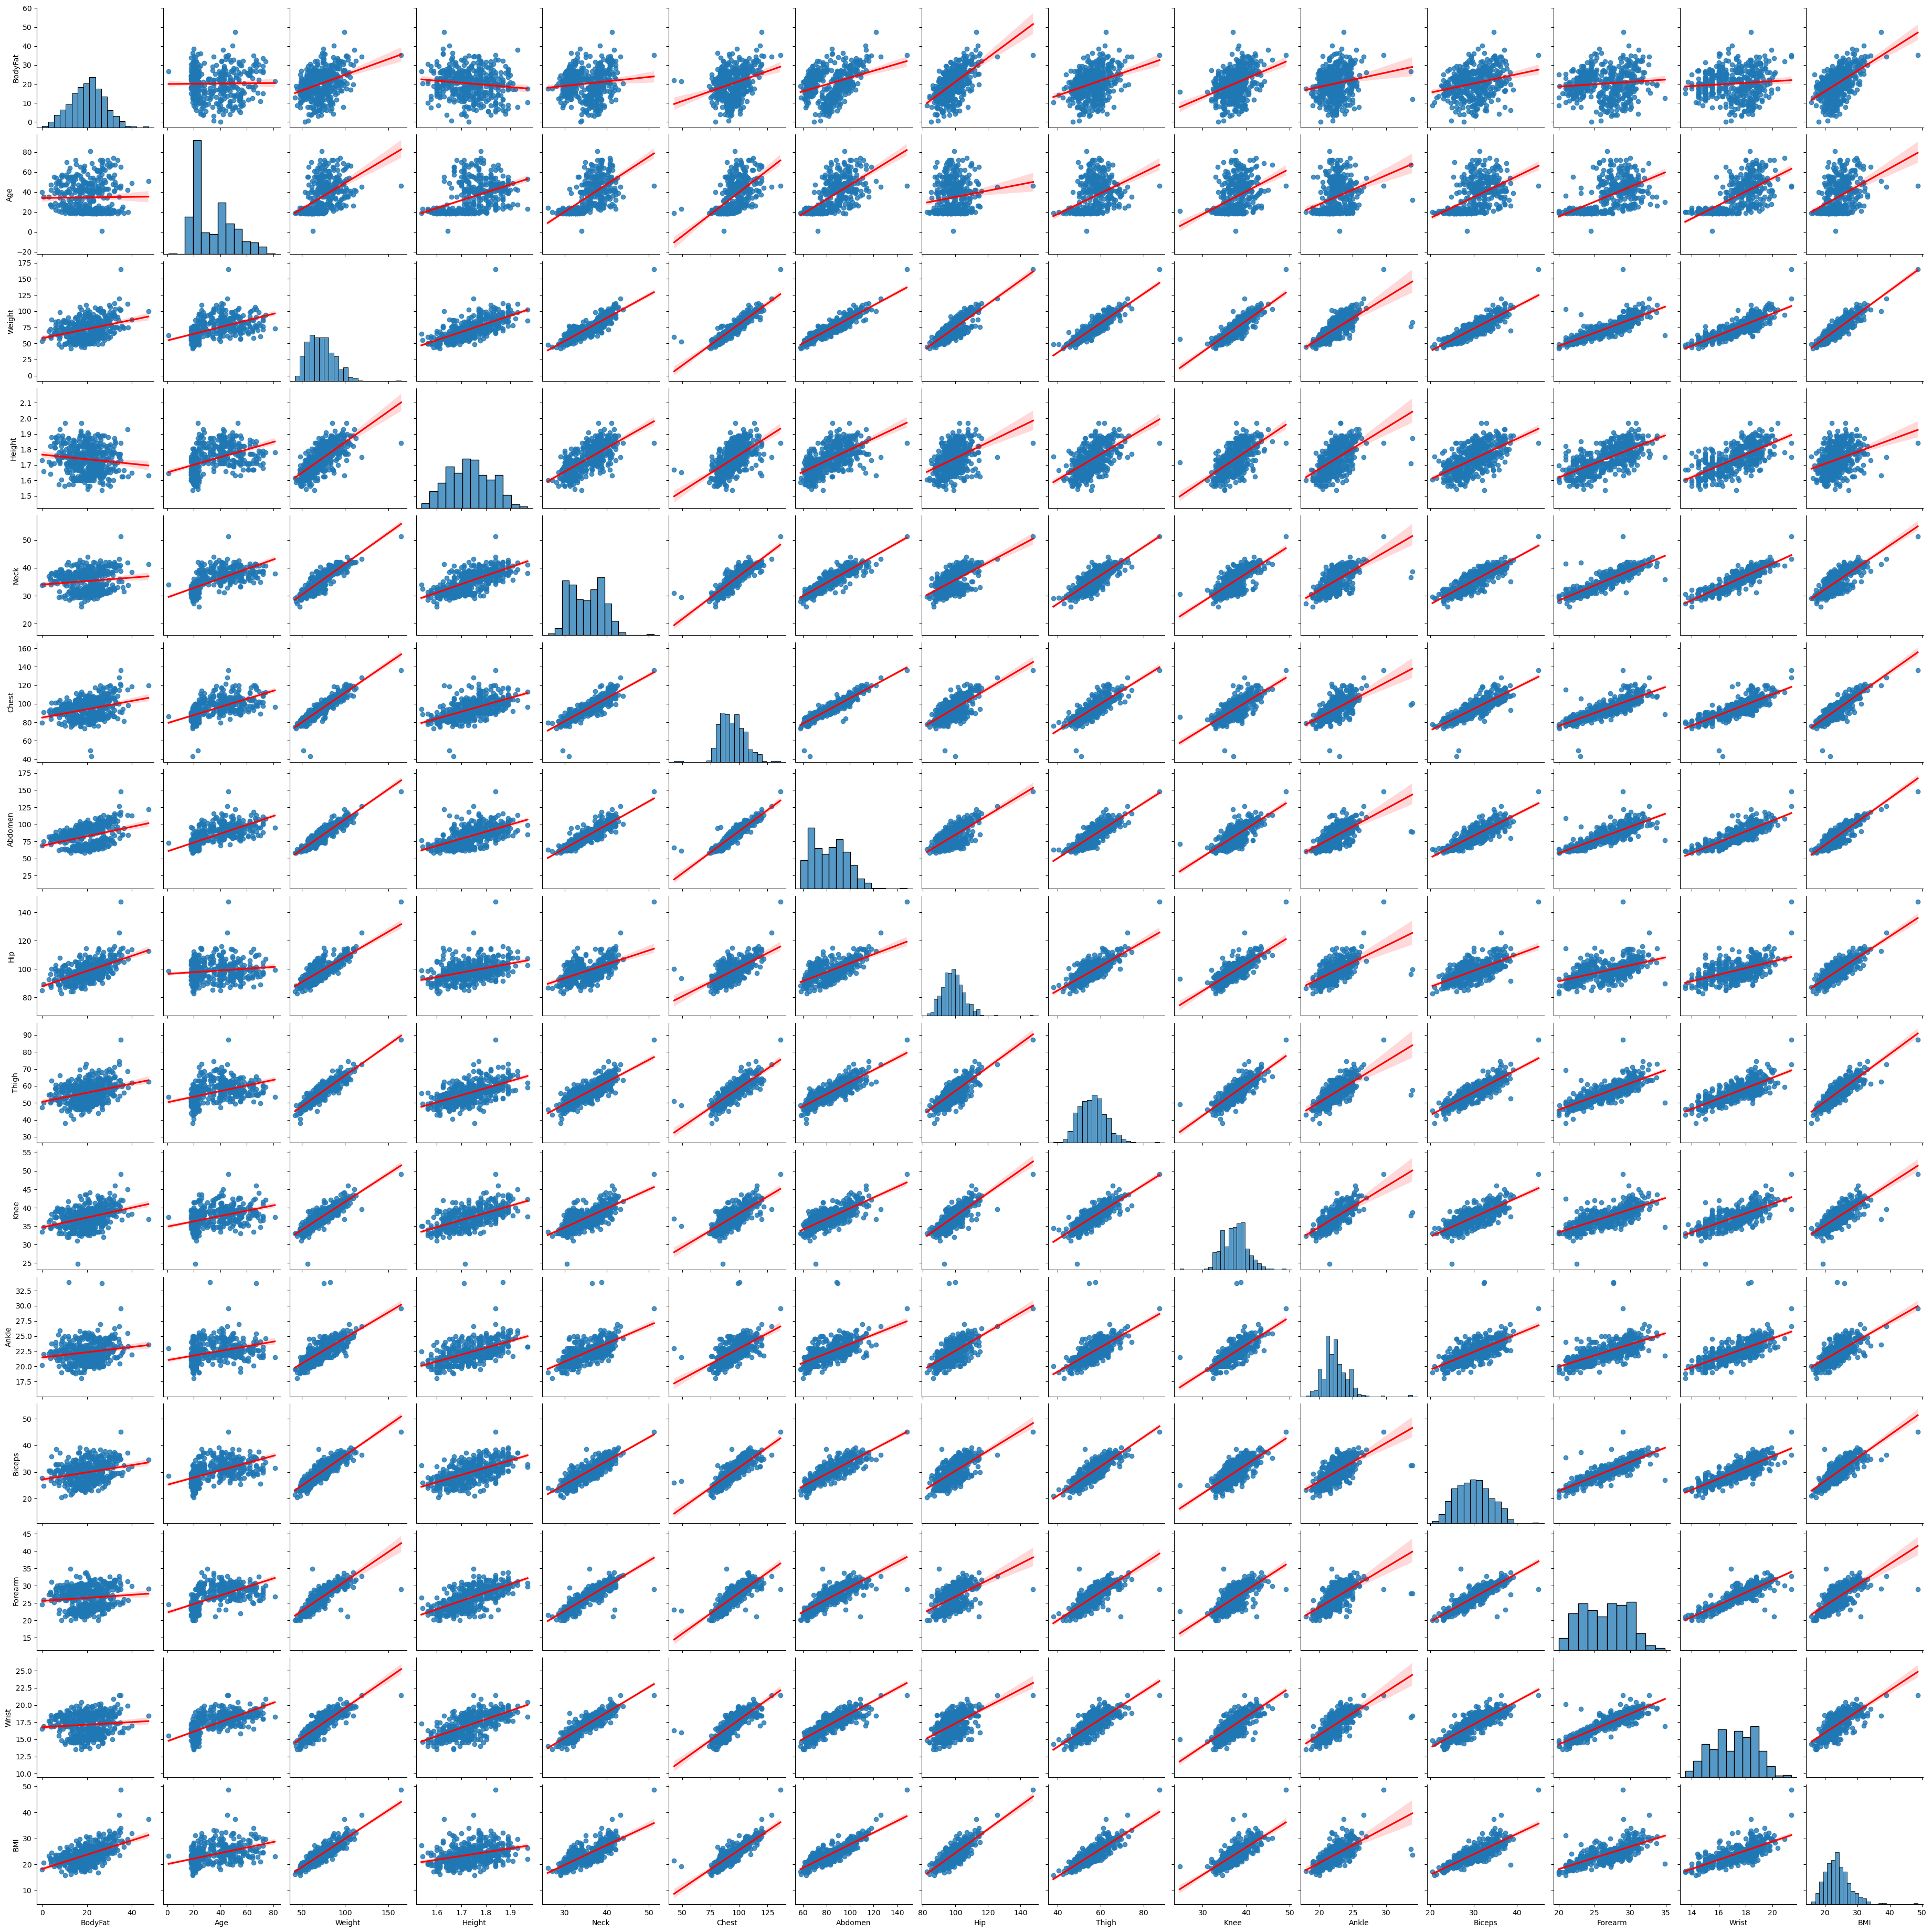

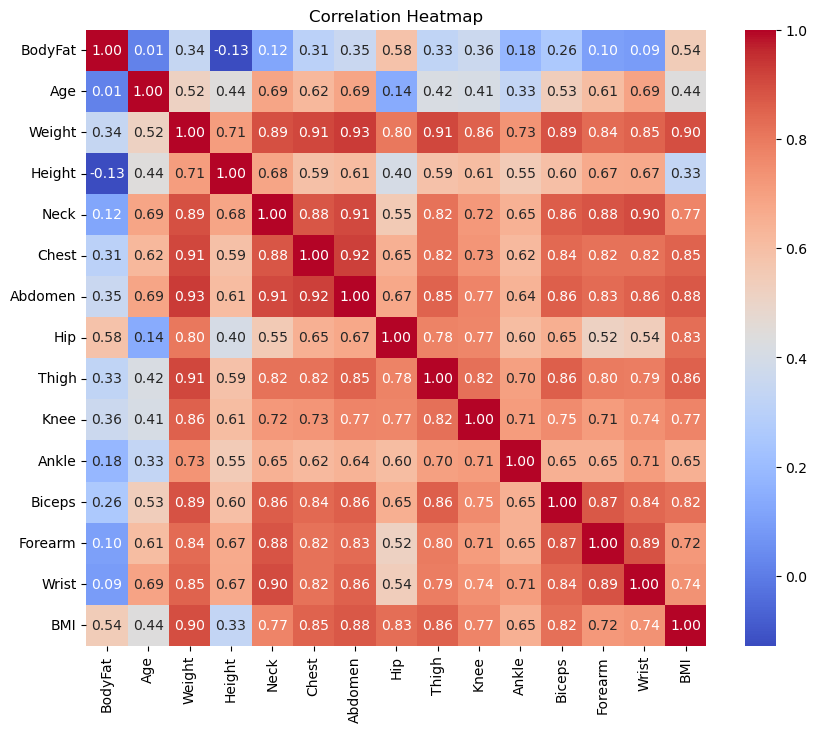

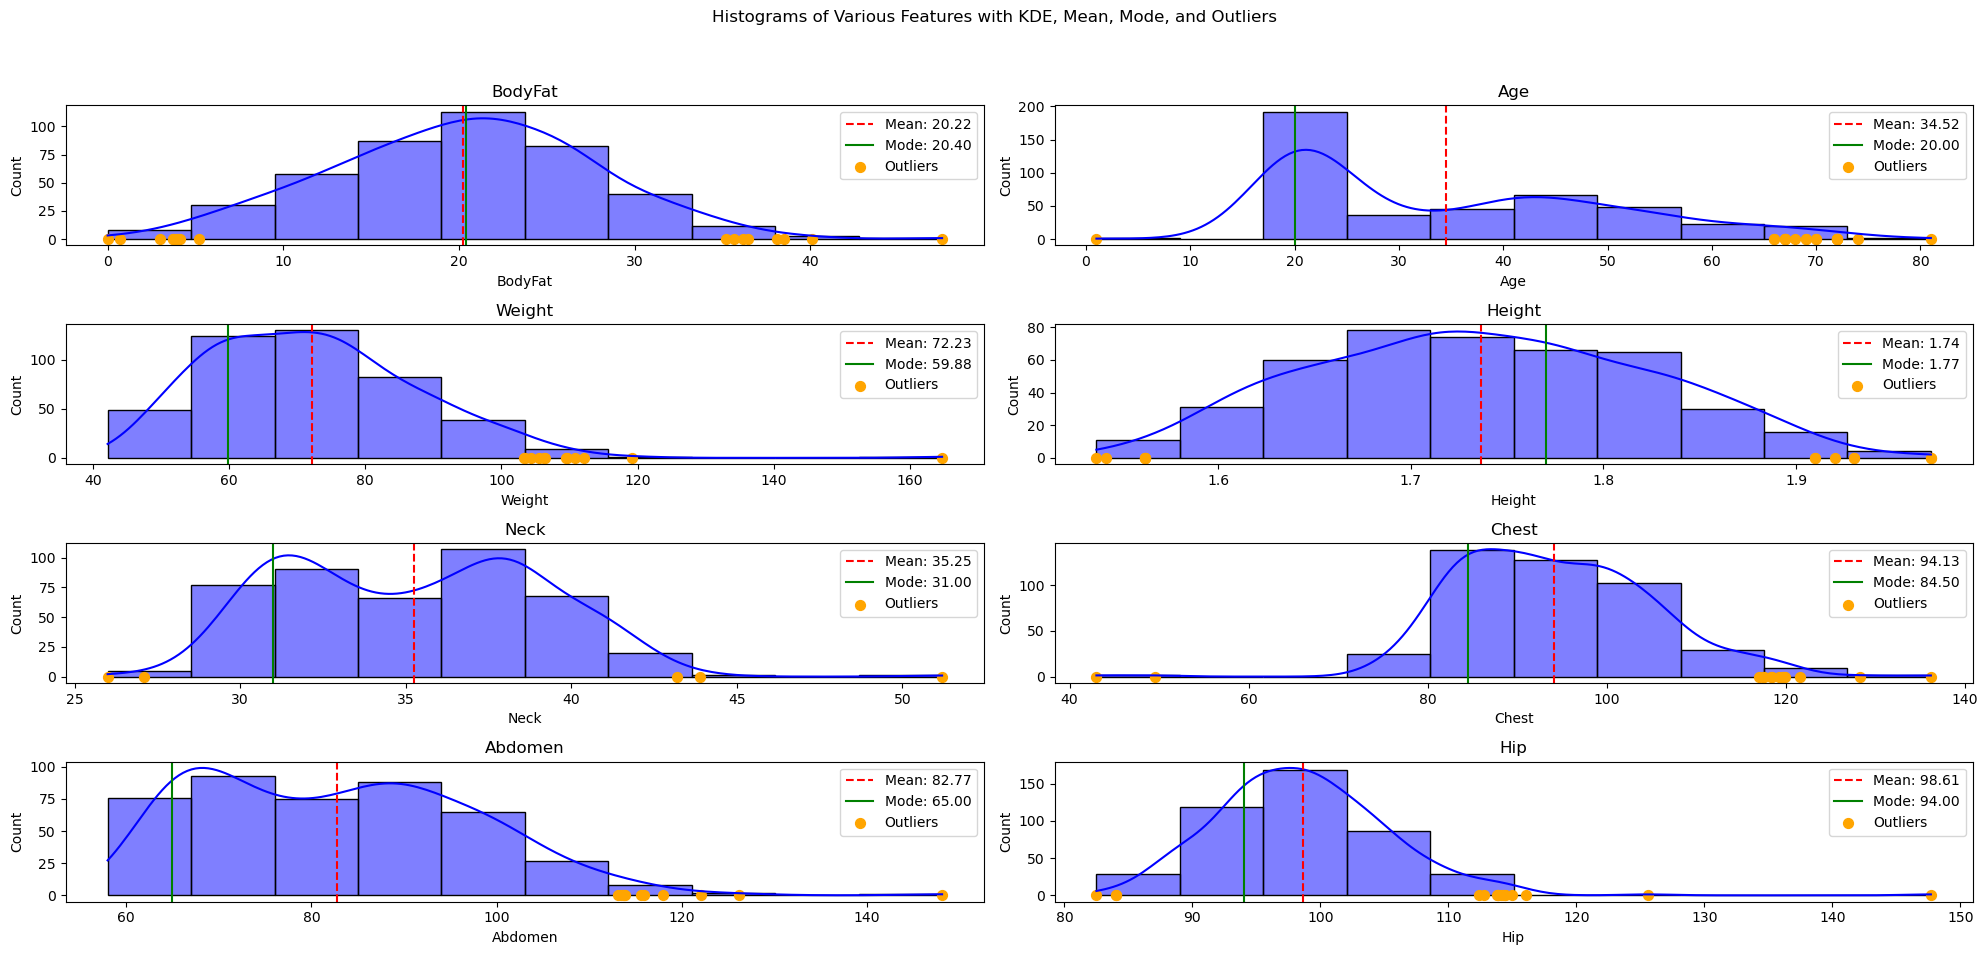


KMeans Silhouette Score: 0.3134782188299282
DBSCAN Silhouette Score: 0.19696149136798888


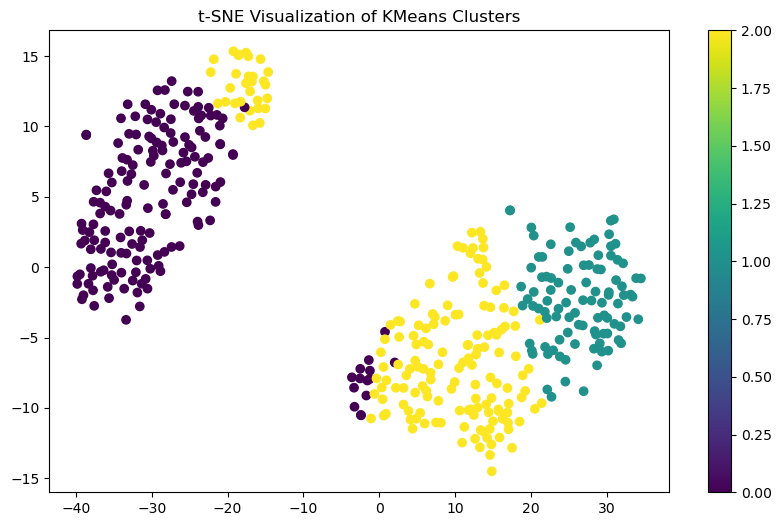

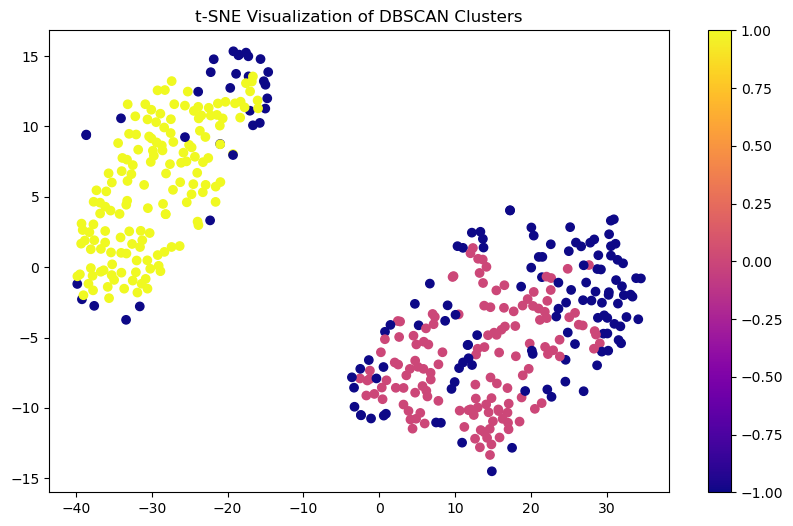

In [ ]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.inspection import PartialDependenceDisplay
from umap import UMAP
from scipy.cluster.hierarchy import dendrogram, linkage
from pathlib import Path
import warnings
from math import pi
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "12"  # set it to how many logical cores you want to use

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*n_jobs value 1 overridden.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*KMeans is known to have a memory leak.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Could not find the number of physical cores.*")

# Load dataset
file_path = Path("C:/Users/AC/Projects/LeanAI/Project/notebooks/EDA/data/kaggle_datasets/body_fat/bodyfat.csv")
df_pl = pl.read_csv(file_path)
df = df_pl.to_pandas()  # For compatibility with Seaborn and sklearn

# Initial info and descriptive stats
print("\n📋 Dataset Info:")
df.info()

print("\n📊 Descriptive Statistics:")
print(df.describe().T)

# Preprocessing
# Fix suspected height/weight inversions
inverted = (df['Height'] < 1.0) & (df['Weight'] > 100)
df.loc[inverted, ['Height', 'Weight']] = df.loc[inverted, ['Weight', 'Height']].values

# Check BMI plausibility and fix extreme values
mask_valid_height = df['Height'] > 0.5  # meters
mask_valid_weight = df['Weight'] > 10   # kg

# Print full rows of invalid height/weight
bmi_check = df[~(mask_valid_height & mask_valid_weight)]
if not bmi_check.empty:
    print("\n⚠️ Invalid height or weight detected:")
    print(bmi_check.to_string(index=False))

# Filter only valid height and weight
df = df[mask_valid_height & mask_valid_weight].copy()
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Flag and drop extreme BMI outliers
df['BMI_outlier'] = (df['BMI'] > 100).astype(int)
bmi_outliers = df[df['BMI_outlier'] == 1]
if not bmi_outliers.empty:
    print("\n⚠️ BMI Outliers Check:")
    print(bmi_outliers.to_string(index=False))
    df = df[df['BMI_outlier'] == 0]
    print("\n🗑 Dropped BMI outliers.")

# Drop helper column
df.drop(columns='BMI_outlier', inplace=True)

# Drop missing values
df.dropna(inplace=True)
df_numeric = df.select_dtypes(include=np.number)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Visualizations: Pairplot
sns.pairplot(df_numeric, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Histograms with KDE, Mean, Mode, Outliers
fig, axes = plt.subplots(4, 2, figsize=(20, 10))
axes = axes.flatten()

for ax, col in zip(axes, df_numeric.columns):
    sns.histplot(df[col], bins=10, kde=True, color='blue', edgecolor='black', ax=ax)
    mean = df[col].mean()
    mode = df[col].mode()[0]
    std_dev = df[col].std()
    outliers = df[col][np.abs(df[col] - mean) > 2 * std_dev]
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    ax.axvline(mode, color='green', linestyle='-', label=f'Mode: {mode:.2f}')
    ax.scatter(outliers, np.zeros_like(outliers) - 0.01, color='orange', s=50, label='Outliers')
    ax.legend()
    ax.set_title(col)

plt.suptitle("Histograms of Various Features with KDE, Mean, Mode, and Outliers")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)
df['KMeans_Cluster'] = kmeans_labels

# DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)
df['DBSCAN_Cluster'] = dbscan_labels

# Cluster Evaluation: Silhouette Score
print("\nKMeans Silhouette Score:", silhouette_score(df_scaled, kmeans_labels))
print("DBSCAN Silhouette Score:", silhouette_score(df_scaled, dbscan_labels))

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("t-SNE Visualization of KMeans Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dbscan_labels, cmap='plasma')
plt.title("t-SNE Visualization of DBSCAN Clusters")
plt.colorbar()
plt.show()

# UMAP Visualization
umap = UMAP(n_components=2, random_state=42)
umap_results = umap.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=kmeans_labels, cmap='cool')
plt.title("UMAP Visualization of KMeans Clusters")
plt.colorbar()
plt.show()

# Hierarchical Clustering
linkage_matrix = linkage(df_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Overlay Clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='BMI', y='BodyFat', hue='KMeans_Cluster', palette='deep')
plt.title("BodyFat vs BMI Colored by KMeans Clusters")
plt.show()

# Violin plots for AgeGroup and Sex
bins = [17, 30, 45, 60, 100]
labels = ['18–30', '31–45', '46–60', '60+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='AgeGroup', y='BodyFat', hue='Sex', split=True)
plt.title("Violin Plot of BodyFat by Age Group and Sex")
plt.show()

# Feature Engineering
categorical_cols = ['Sex', 'AgeGroup']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Flag Outliers
for col in df_numeric.columns:
    mean = df[col].mean()
    std = df[col].std()
    df[f'{col}_outlier'] = (np.abs(df[col] - mean) > 2 * std).astype(int)

# Sex Analysis
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', data=df)
plt.title("Distribution by Sex")
plt.show()

# Sex-based boxplots
key_features = ['BodyFat', 'Weight', 'BMI']
for feature in key_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Sex', y=feature, data=df)
    plt.title(f"{feature} by Sex")
    plt.show()

# Sex-based correlation heatmaps (cleaned and focused)
selected_features = ['BodyFat', 'BMI', 'Weight', 'Age', 'Abdomen']
for sex in df['Sex'].unique():
    sex_df = df[df['Sex'] == sex][selected_features].dropna()
    corr_matrix = sex_df.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"Correlation Heatmap (Top Features) for {sex}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Age Group Boxplots
for feature in key_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='AgeGroup', y=feature, hue='Sex', data=df)
    plt.title(f"{feature} by Age Group and Sex")
    plt.legend()
    plt.show()

# Interaction plot: Age vs. BodyFat with hue=Sex
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Age', y='BodyFat', hue='Sex', style='Sex')
sns.regplot(data=df, x='Age', y='BodyFat', scatter=False, color='black', lowess=True)
plt.title("BodyFat vs. Age by Sex with Trend Line")
plt.show()

# Interactive Dashboard (Optional Example with Plotly)
fig = px.scatter(df, x='BMI', y='BodyFat', color='KMeans_Cluster', hover_data=['Age', 'Sex'])
fig.update_layout(title="Interactive Clustered Scatterplot: BMI vs BodyFat")
fig.show()

# BodyFat Distribution by Sex
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='BodyFat', hue='Sex', kde=True, bins=30)
plt.title("BodyFat Distribution by Sex")
plt.show()

# Correlation with BodyFat by Sex
for sex in df['Sex'].unique():
    corr = df[df['Sex'] == sex].corr(numeric_only=True)['BodyFat'].sort_values(ascending=False)
    print(f"\n🔍 Top correlations with BodyFat for {sex}:")
    print(corr.head(6))

# Feature distribution by cluster
for feature in ['BMI', 'Weight', 'Abdomen']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='KMeans_Cluster', y=feature)
    plt.title(f"{feature} Distribution by KMeans Cluster")
    plt.show()

# BMI vs Abdomen by Cluster
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='BMI', y='Abdomen', hue='KMeans_Cluster', palette='Set2')
plt.title("BMI vs Abdomen by KMeans Cluster")
plt.show()